In [2]:
import pymc3 as pm
import numpy as np 
import matplotlib.pyplot as plt
import theano
%matplotlib inline

### Define a gaussian mixture model 

In [3]:
w = np.array([.2, .8])   ### mixture weights usually use some prior here rather than absolute but for simplicity
mu = np.array([-.3, .5])   #### means for mixtures
sd = np.array([.1, .1])    #### sd for mixtures

with pm.Model() as model:   ### define model 
    x = pm.NormalMixture('x', w=w, mu=mu, sd=sd, dtype=theano.config.floatX)
    x2 = x ** 2
    sin_x = pm.math.sin(x)

### Need  random variables deterministic to sample from them ??

In [4]:
with model:
    pm.Deterministic('x2', x2)
    pm.Deterministic('sin_x', sin_x)

#### take samples from our model

In [5]:
with model:
    trace = pm.sample(50000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x]
100%|██████████| 50500/50500 [00:40<00:00, 1258.13it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


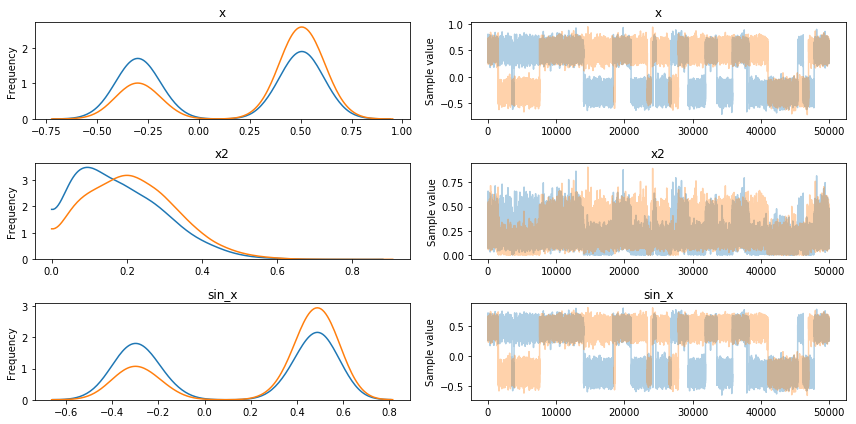

In [6]:
pm.traceplot(trace);

### We will now attempt to use Variational Inference to optimise the approximate distribution. Here we will use the automatic differentiation variational inference (ADVI) algorithm

In [7]:
with model:
    mean_field = pm.fit(method='advi')

Average Loss = 2.0589: 100%|██████████| 10000/10000 [00:12<00:00, 792.51it/s]
Finished [100%]: Average Loss = 2.056


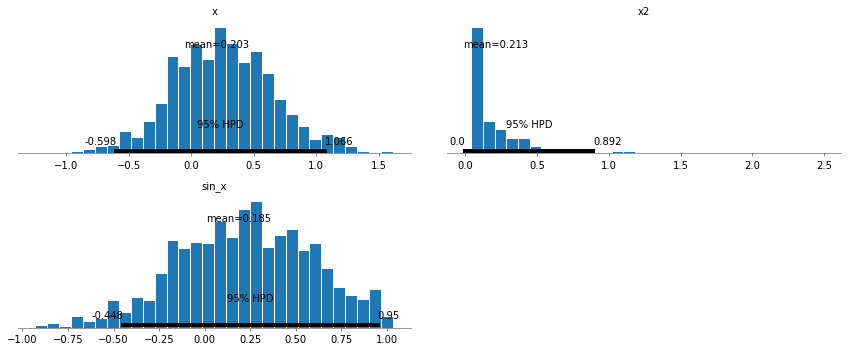

In [8]:
pm.plot_posterior(mean_field.sample(1000));

#### ADVI does not work well here because it is attempting to fit one mode to the bi-modal distribution, this could be a serious drawback if we try to apply this algorithm to GW. Below we will check the convergence of the parameters to have a closer look at what is happening 

In [9]:
from pymc3.variational.callbacks import CheckParametersConvergence

with model:
    mean_field = pm.fit(method='advi', callbacks=[CheckParametersConvergence()])

Average Loss = 1.8828: 100%|██████████| 10000/10000 [00:13<00:00, 741.77it/s]
Finished [100%]: Average Loss = 1.8782


Text(0,0.5,'ELBO')

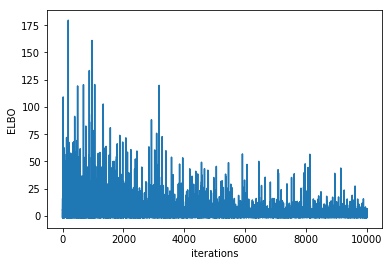

In [10]:
plt.plot(mean_field.hist) ### note here hist means history not histogram, 
                          ###  so the plot is not converging particularly well 
plt.xlabel('iterations')
plt.ylabel('ELBO')

#### We can also track individual parameters, however we must use the object oriented programming (OOP) API

In [11]:
with model:
    advi = pm.ADVI()

In [12]:
advi.approx
### this shows us what approximation we are making in our model

In [13]:
advi.approx.shared_params
### shows hyperparameters

{'mu': mu, 'rho': rho}

In [14]:
advi.approx.mean.eval(), advi.approx.std.eval()
### shows statistsics for hyperparameters, we can then track these below

(array([ 0.34]), array([ 0.69314718]))

In [15]:
tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,  # callable that returns mean
    std=advi.approx.std.eval  # callable that returns std
)

In [16]:
approx = advi.fit(100000, callbacks=[tracker])


Average Loss = 1.9676: 100%|██████████| 100000/100000 [02:51<00:00, 583.26it/s]
Finished [100%]: Average Loss = 1.9443


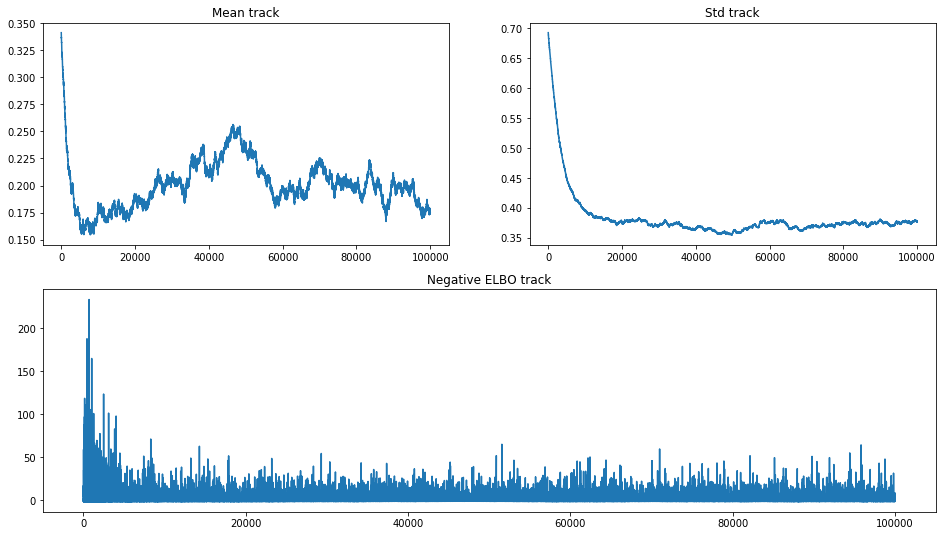

In [17]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(advi.hist)
hist_ax.set_title('Negative ELBO track');

### comparing the results for VI v sampling, we see that the ADVI algorithm fails to capture the multi-modal nature of the data. 

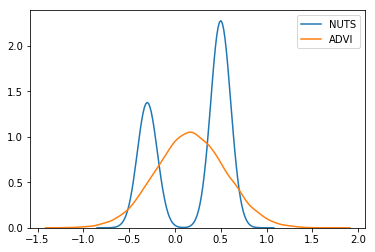

In [18]:
import seaborn as sns
ax = sns.kdeplot(trace['x'], label='NUTS');
sns.kdeplot(approx.sample(10000)['x'], label='ADVI');

#### Let's try a different algorithm, we will use SVGD (need to read this paper:https://arxiv.org/pdf/1608.04471.pdf)

In [19]:
with model:
    svgd_approx = pm.fit(300, method='svgd', inf_kwargs=dict(n_particles=1000),
                         obj_optimizer= pm.sgd(learning_rate=0.01))

100%|██████████| 300/300 [00:56<00:00,  5.30it/s]


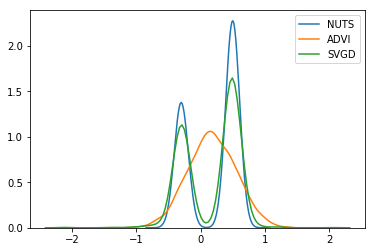

In [20]:
ax = sns.kdeplot(trace['x'], label='NUTS');
sns.kdeplot(approx.sample(10000)['x'], label='ADVI');
sns.kdeplot(svgd_approx.sample(2000)['x'], label='SVGD');

## SVGD is able to capture the distribution better --potentially worth trying with ligo data

In [22]:
trace['x']

array([ 0.54297011,  0.59024123,  0.60986007, ...,  0.37748287,
        0.62279702,  0.63700739])

In [ ]:
with pm.Model() as inc_model:
    